In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 48.3MB/s]


In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images[:4])
img_grid_np = img_grid.numpy().transpose((1, 2, 0))

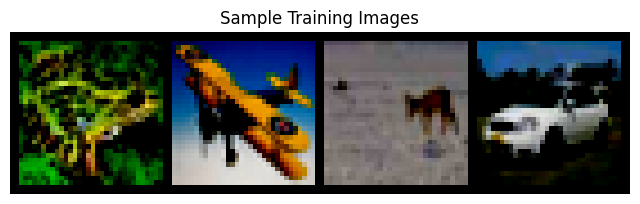

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(img_grid_np)
plt.title('Sample Training Images')
plt.axis('off')
plt.savefig('sample_training_images.png')
plt.show()

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

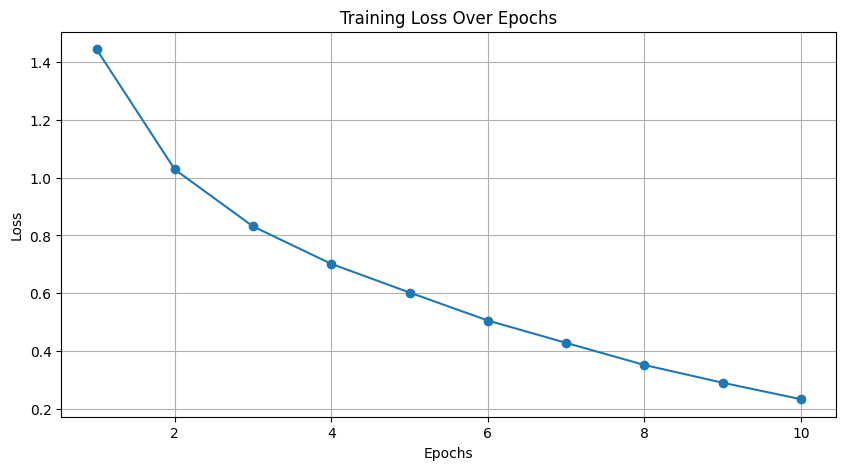

In [7]:
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def create_adversarial_examples(model, images, labels, epsilon=0.03):
  images.requires_grad = True
  outputs = model(images)
  loss = criterion(outputs, labels)
  model.zero_grad()
  loss.backward()
  data_grad = images.grad.data
  sign_data_grad = data_grad.sign()
  perturbed_images = images + epsilon * sign_data_grad
  perturbed_images = torch.clamp(perturbed_images, -1, 1)
  return perturbed_images

def train_model(model, optimizer, num_epochs=10):
  model.train()
  epoch_losses = []
  for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    epoch_losses.append(running_loss / len(trainloader))

  plt.figure(figsize=(10, 5))
  plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
  plt.title('Training Loss Over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.grid(True)
  plt.savefig('training_loss_plot.png')
  plt.show()

train_model(model, optimizer)


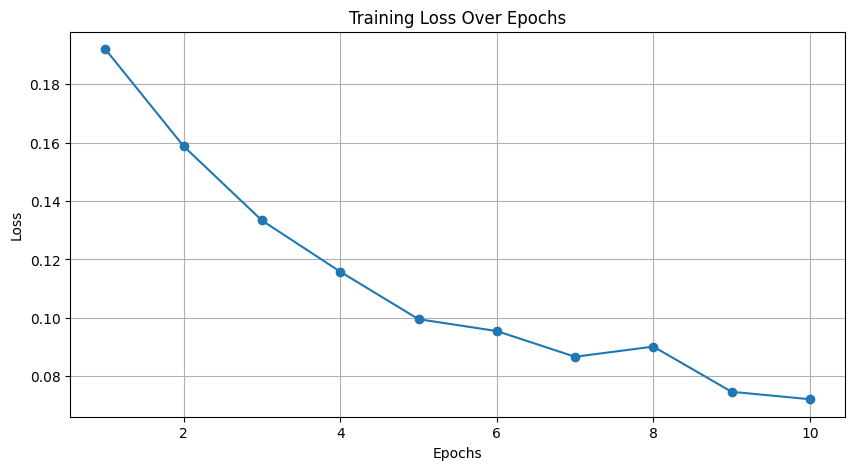

Clean Accuracy: 76.65%
Adversarial Accuracy: 76.65%


In [9]:
def evaluate_model(model, dataloader):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for data in dataloader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  return 100 * correct / total

train_model(model, optimizer, num_epochs=10)

clean_accuracy = evaluate_model(model, testloader)
print(f"Clean Accuracy: {clean_accuracy:.2f}%")

adv_accuracy = evaluate_model(model, testloader)
print(f"Adversarial Accuracy: {adv_accuracy:.2f}%")
